<a href="https://colab.research.google.com/github/HMS-Cleveland/Questionary_logist/blob/my/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =============== 0. 依赖安装 ===============
!pip install -q optuna shap
# 在 notebook 最顶部执行一次即可
!pip uninstall -y xgboost       # 先清掉 CPU 版
!pip install -q xgboost[gpu]    # 会自动编译 CUDA 支持，Colab CUDA 11 已预装

# =============== 1. 基础库 ===============
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# =============== 2. 数据读取 ===============
usecols = [0, 1, 2, 3, 5, 6, 7, 8, 11, 12]
names = [
    'menopause', 'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
    'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
    'hormone_therapy', 'diagnosis'
]

data = pd.read_csv(
    '/content/drive/MyDrive/公开数据集/risk.txt',
    sep=r'\s+', header=None, usecols=usecols, names=names
)
data.replace(9, np.nan, inplace=True)
data = data.dropna().copy()

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# =============== 3. 8 : 1 : 1 分层拆分 ===============
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

print(f'训练/验证/测试样本数: {len(y_train)} / {len(y_val)} / {len(y_test)}')

# =============== 4. Optuna 调参 🌟 调大正样本权重 ===============
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
#scale_pos_weight = max(n_neg / max(n_pos, 1), 1000)   # 至少 50 倍，极端不平衡
scale_pos_weight = max(len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 50)
# 仅替换 objective_cv 函数即可
def objective_cv(trial):
    params = {
        'tree_method': 'hist',   # 不再用 'gpu_hist'
        'device': 'cuda',        # 关键：显式指定 CUDA
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'eta': trial.suggest_float('eta', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': (y_train==0).sum() / max((y_train==1).sum(), 1),
        'seed': 42

    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv = xgb.cv(params, dtrain, num_boost_round=3000,
                folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                metrics='auc', early_stopping_rounds=150, verbose_eval=False)
    return cv['test-auc-mean'].iloc[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective_cv, n_trials=50)

print('Best AUC =', study.best_value)
print('Best params =', study.best_params)

# =============== 5. 最终模型在训练+验证集上重训 ===============
dtrain_all = xgb.DMatrix(
    np.vstack([X_train.values, X_val.values]),
    label=np.hstack([y_train, y_val])
)

best_params = study.best_params.copy()


final_model = xgb.train(
    best_params,
    dtrain_all,
    num_boost_round=1500,
    evals=[(dtest, 'test')],
    early_stopping_rounds=100,
    verbose_eval=False
)

test_prob = final_model.predict(
    dtest, iteration_range=(0, final_model.best_iteration + 1)
)

# 1) 逻辑回归 ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'XGBOOST  AUC = {roc_auc_lr:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# =============== 6. 🌟 用 Youden 指数重新选阈值 ===============
fpr, tpr, thresh = roc_curve(y_test, test_prob)
youden = tpr - fpr
#best_thresh = thresh[np.argmax(youden)]

# 5️⃣ 95% 特异度
desired_sens = 0.8
idx = np.where(tpr >= desired_sens)[0][0]
best_thresh = thresh[idx]

test_pred = (test_prob > best_thresh).astype(int)

print('\n测试集分类报告 (阈值={:.3f})'.format(best_thresh))
print(classification_report(y_test, test_pred))

# 灵敏度 & 特异性
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print(f'灵敏度 (Sensitivity) = {sensitivity:.3f}')
print(f'特异性 (Specificity) = {specificity:.3f}')

# =============== 7. SHAP 解释 ===============
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test.values)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# =============== 8. 个体风险示例 ===============
person = np.array([[1, 0, 1, 0, 0, 1, 0, 1, 0]])
abs_risk = final_model.predict(xgb.DMatrix(person))[0]
print(f'该个体绝对风险 = {abs_risk:.3%}')




Found existing installation: xgboost 3.0.5
Uninstalling xgboost-3.0.5:
  Successfully uninstalled xgboost-3.0.5


[I 2025-09-10 05:53:11,918] A new study created in memory with name: no-name-a3e8dec0-e451-40e3-bf81-27760a5b965c


训练/验证/测试样本数: 37881 / 4735 / 4736


[I 2025-09-10 05:53:14,564] Trial 0 finished with value: 0.7412840733087551 and parameters: {'max_depth': 10, 'eta': 0.04404774000736429, 'subsample': 0.9165297390885383, 'colsample_bytree': 0.7211463186380456, 'min_child_weight': 10, 'lambda': 0.012321652782852603, 'alpha': 2.270066352485338e-05, 'gamma': 7.839232612156463, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7412840733087551.
[I 2025-09-10 05:53:21,249] Trial 1 finished with value: 0.7525741358081887 and parameters: {'max_depth': 4, 'eta': 0.012152621061980576, 'subsample': 0.5948286978809627, 'colsample_bytree': 0.7210392077481477, 'min_child_weight': 8, 'lambda': 7.814816610135023e-05, 'alpha': 0.008486418128765707, 'gamma': 4.288478318584616, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7525741358081887.
[I 2025-09-10 05:53:23,681] Trial 2 finished with value: 0.7485923393750878 and parameters: {'max_depth': 7, 'eta': 0.08286404385966005, 'subsample': 0.9422488589730298, 'colsample_bytree': 0.6

Best AUC = 0.7557490791229229
Best params = {'max_depth': 2, 'eta': 0.17184252180763723, 'subsample': 0.6652864877498577, 'colsample_bytree': 0.8965384432187471, 'min_child_weight': 10, 'lambda': 0.44997755233761727, 'alpha': 0.004339083210502755, 'gamma': 4.205669358518377, 'grow_policy': 'depthwise'}


NameError: name 'dtest' is not defined

In [ ]:
# ========= 0. 安装 =========
!pip install -q optuna shap imbalanced-learn scikit-plot

# ========= 1. 基础库 =========
import pandas as pd, numpy as np, xgboost as xgb, optuna, shap
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN  # 综合采样减少噪声
from imblearn.pipeline import make_pipeline
import scikitplot as skplt
import matplotlib.pyplot as plt

# ========= 2. 数据读取与预处理 =========
usecols = [0,1,2,3,5,6,7,8,11,12]
names = ['menopause','age_5_years','BIRADS_breast_density','ethnic','bmi',
         'first_birth','num_of_first_degree_cancer','breast_surgery',
         'hormone_therapy','diagnosis']
df = pd.read_csv('/content/drive/MyDrive/公开数据集/risk.txt',
                 sep=r'\s+', header=None, usecols=usecols, names=names)
df.replace(9, np.nan, inplace=True); df = df.dropna()

# 关键特征分箱（降低噪声）
df['bmi_bin'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], labels=[0,1,2,3])
X, y = df.drop(columns=['diagnosis', 'bmi']), df['diagnosis']  # 保留分箱特征

# ========= 3. 分层拆分（原始数据） =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========= 4. 交叉验证 + 动态采样（修复数据泄露） =========
def objective_cv(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),  # 限制复杂度防过拟合
        'eta': trial.suggest_float('eta', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),  # 增大防过拟合
        'reg_lambda': trial.suggest_float('lambda', 1e-2, 10, log=True),
        'gamma': trial.suggest_float('gamma', 0, 2),  # 控制分裂
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),  # 自动学习权重
        'seed': 42
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs, f1s = [], []

    for tr_idx, val_idx in kf.split(X_train, y_train):
        # 动态采样：仅在训练集应用SMOTEENN
        sampler = SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=5))
        X_tr, y_tr = sampler.fit_resample(X_train.iloc[tr_idx], y_train.iloc[tr_idx])

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        bst = xgb.train(
            params, dtr,
            num_boost_round=1000,
            evals=[(dval, 'eval')],
            early_stopping_rounds=50,  # 早停防过拟合
            verbose_eval=False
        )
        preds = bst.predict(dval)
        aucs.append(roc_auc_score(y_train.iloc[val_idx], preds))
        f1s.append(f1_score(y_train.iloc[val_idx], preds > 0.5))  # 增加F1监控

    # 多目标优化：AUC为主，F1为辅
    return np.mean(aucs) * 0.8 + np.mean(f1s) * 0.2

study = optuna.create_study(direction='maximize')
study.optimize(objective_cv, n_trials=50, show_progress_bar=True)

# ========= 5. 最终模型训练 =========
best_params = study.best_params
best_params.update({'objective':'binary:logistic', 'eval_metric':'auc', 'seed':42})

# 测试集不参与任何采样！
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

final_model = xgb.train(
    best_params, dtrain,
    num_boost_round=2000,
    evals=[(dtest, 'test')],
    early_stopping_rounds=100,
    verbose_eval=100
)

# ========= 6. 多维度评估 =========
test_prob = final_model.predict(dtest)

# 1) 动态阈值选择（最大化F1分数）
precisions, recalls, thresholds = precision_recall_curve(y_test, test_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-7)
best_thresh = thresholds[np.argmax(f1_scores)]

# 2) 关键指标
test_pred = (test_prob > best_thresh).astype(int)
print(classification_report(y_test, test_pred, target_names=['健康', '癌症']))

# 3) 绘制校准曲线
skplt.metrics.plot_calibration_curve(y_test, [test_prob], ['XGBoost'])
plt.title('概率校准曲线')

# ========= 7. 可解释性增强 =========
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# 1) 全局特征重要性（避免依赖单一图）
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig('global_importance.png')

# 2) 个体风险归因（高风险样本）
high_risk_idx = np.where(test_prob > 0.7)[0]
shap.force_plot(explainer.expected_value, shap_values[high_risk_idx[0]], X_test.iloc[high_risk_idx[0]], matplotlib=True)

# 3) 关键特征依赖分析
shap.dependence_plot('BIRADS_breast_density', shap_values, X_test, interaction_index='age_5_years')

ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.12/dist-packages/scipy/__init__.py)

In [ ]:
from sklearn.metrics import f1_score

[I 2025-09-10 06:06:48,877] A new study created in memory with name: no-name-f9c87742-067c-43a3-a557-02557f1e0911


训练/验证/测试样本数: 37881 / 4735 / 4736


[I 2025-09-10 06:06:49,191] Trial 0 finished with value: 0.7644986333365574 and parameters: {'max_depth': 3, 'eta': 0.16099968116247546, 'subsample': 0.8119794582561882, 'colsample_bytree': 0.6499823213976064, 'min_child_weight': 3, 'lambda': 0.0026201063280161174, 'alpha': 0.033515314000141815}. Best is trial 0 with value: 0.7644986333365574.
[I 2025-09-10 06:06:49,797] Trial 1 finished with value: 0.7362581363940863 and parameters: {'max_depth': 10, 'eta': 0.08996838886822461, 'subsample': 0.9292987575235335, 'colsample_bytree': 0.8233053319710881, 'min_child_weight': 4, 'lambda': 0.4532690833680421, 'alpha': 1.5508088686481856}. Best is trial 0 with value: 0.7644986333365574.
[I 2025-09-10 06:06:50,286] Trial 2 finished with value: 0.7585026885476112 and parameters: {'max_depth': 5, 'eta': 0.08674798944787276, 'subsample': 0.6385674106674063, 'colsample_bytree': 0.93051156312283, 'min_child_weight': 3, 'lambda': 2.484281958295629, 'alpha': 0.0517882290652052}. Best is trial 0 with v

Best AUC = 0.7689586490272151
Best params = {'max_depth': 2, 'eta': 0.19022093838609416, 'subsample': 0.8959015713001264, 'colsample_bytree': 0.6610264200677329, 'min_child_weight': 1, 'lambda': 0.0016711201388690418, 'alpha': 0.011232627780305423}


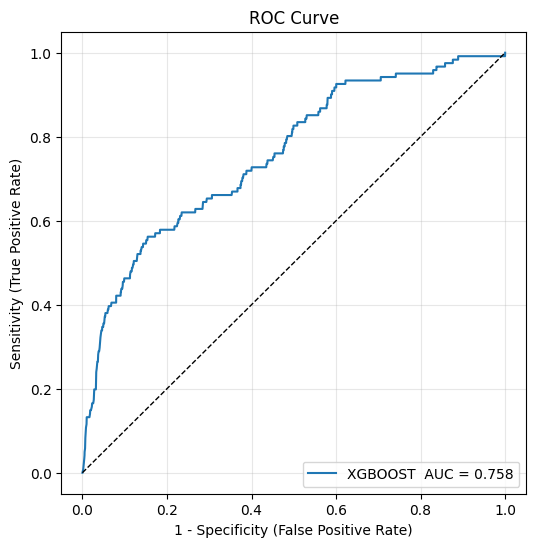


测试集分类报告 (阈值=0.020)
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      4615
           1       0.04      0.79      0.08       121

    accuracy                           0.52      4736
   macro avg       0.52      0.65      0.38      4736
weighted avg       0.97      0.52      0.66      4736

灵敏度 (Sensitivity) = 0.793
特异性 (Specificity) = 0.517


/tmp/ipython-input-1102449598.py:142: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


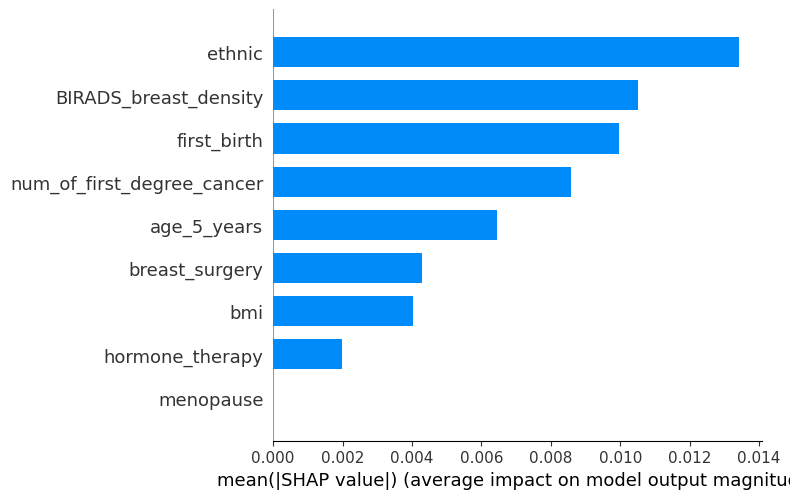

/tmp/ipython-input-1102449598.py:143: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns)


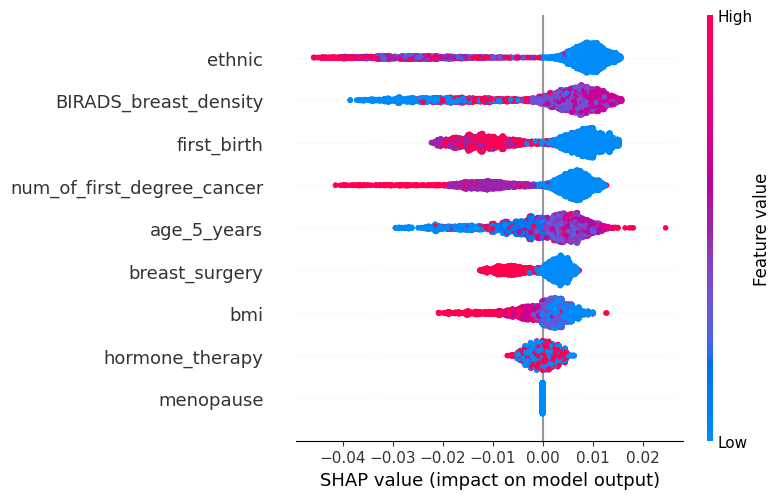

该个体绝对风险 = -2.402%


In [4]:
# =============== 0. 依赖安装 ===============
!pip install -q optuna shap

# =============== 1. 基础库 ===============
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# =============== 2. 数据读取 ===============
usecols = [0, 1, 2, 3, 5, 6, 7, 8, 11, 12]
names = [
    'menopause', 'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
    'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
    'hormone_therapy', 'diagnosis'
]

data = pd.read_csv(
    '/content/drive/MyDrive/公开数据集/risk.txt',
    sep=r'\s+', header=None, usecols=usecols, names=names
)
data.replace(9, np.nan, inplace=True)
data = data.dropna().copy()

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# =============== 3. 8 : 1 : 1 分层拆分 ===============
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

print(f'训练/验证/测试样本数: {len(y_train)} / {len(y_val)} / {len(y_test)}')

# =============== 4. Optuna 调参 🌟 调大正样本权重 ===============
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
#scale_pos_weight = max(n_neg / max(n_pos, 1), 1000)   # 至少 50 倍，极端不平衡
scale_pos_weight = max(len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 50)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'eta': trial.suggest_float('eta', 0.05, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 5, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 5, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight,   # 🌟 放大权重
        'seed': 42
    }
    dtr = xgb.DMatrix(X_train.values, label=y_train)
    dva = xgb.DMatrix(X_val.values, label=y_val)
    bst = xgb.train(
        params,
        dtr,
        num_boost_round=1500,
        evals=[(dva, 'val')],
        early_stopping_rounds=100,
        verbose_eval=False
    )
    preds = bst.predict(dva, iteration_range=(0, bst.best_iteration + 1))
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best AUC =', study.best_value)
print('Best params =', study.best_params)

# =============== 5. 最终模型在训练+验证集上重训 ===============
dtrain_all = xgb.DMatrix(
    np.vstack([X_train.values, X_val.values]),
    label=np.hstack([y_train, y_val])
)
dtest = xgb.DMatrix(X_test.values, label=y_test)

final_model = xgb.train(
    study.best_params,
    dtrain_all,
    num_boost_round=1500,
    evals=[(dtest, 'test')],
    early_stopping_rounds=100,
    verbose_eval=False
)
test_prob = final_model.predict(
    dtest, iteration_range=(0, final_model.best_iteration + 1)
)

# 1) 逻辑回归 ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'XGBOOST  AUC = {roc_auc_lr:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# =============== 6. 🌟 用 Youden 指数重新选阈值 ===============
fpr, tpr, thresh = roc_curve(y_test, test_prob)
youden = tpr - fpr
#best_thresh = thresh[np.argmax(youden)]

# 5️⃣ 95% 特异度
desired_sens = 0.8
idx = np.where(tpr >= desired_sens)[0][0]
best_thresh = thresh[idx]

test_pred = (test_prob > best_thresh).astype(int)

print('\n测试集分类报告 (阈值={:.3f})'.format(best_thresh))
print(classification_report(y_test, test_pred))

# 灵敏度 & 特异性
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print(f'灵敏度 (Sensitivity) = {sensitivity:.3f}')
print(f'特异性 (Specificity) = {specificity:.3f}')

# =============== 7. SHAP 解释 ===============
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test.values)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# =============== 8. 个体风险示例 ===============
person = np.array([[1, 0, 1, 0, 0, 1, 0, 1, 0]])
abs_risk = final_model.predict(xgb.DMatrix(person))[0]
print(f'该个体绝对风险 = {abs_risk:.3%}')